In [78]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_yaml
from keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
import os

import common
from importlib import reload
%matplotlib inline


In [141]:
#
# Parameters
#
split = 7500
max_features = 5000
maxlen = 100
batch_size = 32
embedding_dims = 100
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10


In [142]:
#
# Load the dataset
#
reload(common)

(train_sentences, train_categories, test_sentences, test_categories) = common.load_dataset('../dataset/redis_dataset.csv', split=0.7)
print(train_sentences.shape)

9849
(6894,)


In [143]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

dictionary = tokenizer.word_index

print('Found %s unique tokens.' % len(dictionary))

# Let's save this out so we can use it later
with open('models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)


Found 5094 unique tokens.


In [133]:
#
# Load Glove embeddings
#
glove_dir = '/Users/nscsekhar/Desktop/nscsekhar/Desktop/Surya/Personal/MIDS/W266/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#
# Get Embedding matrix
#
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, i in dictionary.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [144]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (6894, 100)
x_test shape: (2955, 100)


In [145]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
#                     weights=[embedding_matrix],
#                     trainable=False,
                    input_length=maxlen))

# model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.1))

# model.add(layers.Bidirectional(layers.LSTM(32)))

model.add(Dense(1, activation='sigmoid'))
# model.add(Dropout(0.1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

tbCallback = TensorBoard(log_dir='./logs/rnn', histogram_freq=0,
                          write_graph=True, write_images=False)
metrics = common.Metrics()

history = model.fit(x_train, train_categories,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, test_categories),
          callbacks=[metrics, tbCallback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 517,057
Trainable params: 517,057
Non-trainable params: 0
_________________________________________________________________
None
Train on 6894 samples, validate on 2955 samples
Epoch 1/5
6894/6894 [==============================] - 21s 3ms/step - loss: 0.5536 - acc: 0.7074 - val_loss: 0.4749 - val_acc: 0.7631
Epoch 2/5
6894/6894 [==============================] - 21s 3ms/step - loss: 0.367

Precision: 0.7591836734693878
Recall: 0.7076780758556892
F1: 0.7203389830508474


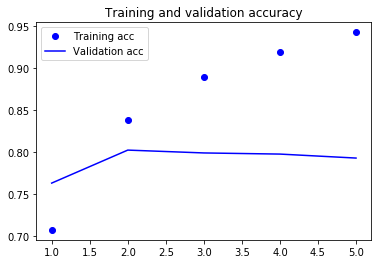

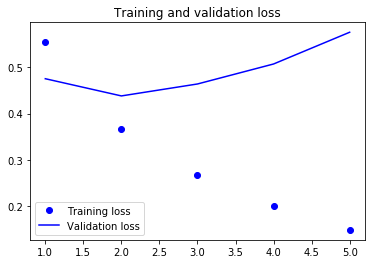

In [146]:
reload(common)
metrics.print_all()

common.plot_model_history(history)

In [90]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [91]:
#
# Save the model as a yaml
#
model_yaml = model.to_yaml()
with open("models/rnn_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("models/rnn_model.h5")
print("Saved model to disk")


Saved model to disk


In [92]:
# load YAML and create model
yaml_file = open("models/rnn_model.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("models/rnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, test_categories, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 78.77%


In [93]:
#
# Load a new source file
#
# reload(common)
test_file='/tmp/fe-connect.c'
comment_sents = []

#
# Get comment sentences
#
comment_sents += common.get_comment_sents(test_file)
# print(len(comment_sents))
# for sent in comment_sents:
#     print(sent)


In [103]:
#
# Predict the comment sentences
#
reload(common)
import json

pred_tokenizer = Tokenizer(num_words=max_features)
labels = ['Good Comment', 'Needs Fix']

with open('models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

for sent in comment_sents:
    print("Sentence: \n",sent)
    comment_sequence = common.convert_text_to_index_array(sent, dictionary)
    comment_vector = sequence.pad_sequences([comment_sequence], maxlen=maxlen)

    pred = loaded_model.predict_classes(comment_vector)
    print("Readability score: ", labels[int(pred)])

    #print("%s sentiment; %f%% confidence" % (labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))
    

Sentence: 
  mstcpip.h is missing on mingw
Readability score:  Good Comment
Sentence: 
  OpenLDAP deprecates RFC 1823, but we want standard conformance
Readability score:  Good Comment
Sentence: 
   Pre-9.0 servers will return this SQLSTATE if asked to set  application_name in a startup packet.
Readability score:  Good Comment
Sentence: 
 We hard-wire the value rather  than looking into errcodes.h since it reflects historical behavior  rather than that of the current code.


InvalidArgumentError: indices[0,65] = 4446 is not in [0, 4000)
	 [[Node: embedding_17_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_17_1/embeddings/read, embedding_17_1/Cast)]]

Caused by op 'embedding_17_1/Gather', defined at:
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-92-014be2b304f6>", line 6, in <module>
    loaded_model = model_from_yaml(loaded_model_yaml)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/models.py", line 333, in model_from_yaml
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 144, in deserialize_keras_object
    list(custom_objects.items())))
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/models.py", line 1373, in from_config
    model.add(layer)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/models.py", line 467, in add
    layer(x)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/layers/embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1211, in gather
    return tf.gather(reference, indices)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2486, in gather
    params, indices, validate_indices=validate_indices, name=name)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1834, in gather
    validate_indices=validate_indices, name=name)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/nscsekhar/anaconda/envs/w266/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[0,65] = 4446 is not in [0, 4000)
	 [[Node: embedding_17_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_17_1/embeddings/read, embedding_17_1/Cast)]]
